# NDVI fourier -> ag

Sources:
- https://www.scielo.br/pdf/pab/v47n9/12.pdf

In [1]:
from pathlib import Path

import numpy as np
import rasterio as rio
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [2]:
dir_in = Path("../data/ndvi")
ft_out = dir_in / "fourier1.tif"
pred_out = dir_in / "pred1.tif"
tifs = [f for f in dir_in.iterdir() if f.suffix == ".tif" and "fourier" not in f.stem]

In [3]:
arrs = []
prof = None
for f in tifs:
    with rio.open(f) as ds:
        arrs.append(ds.read(1))
        if prof is None:
            prof = ds.profile

In [4]:
st = np.stack(arrs)
st.shape

(13, 7127, 5567)

In [5]:
# n=6 gives only positive frequencies
# for now we'll just use n=3 (sort of going by the paper)
# use abs to convert to real numbers
ft = np.abs(np.fft.fft(st, n=6, axis=0))
ft.shape

(6, 7127, 5567)

In [6]:
# plt.imshow(ft[1, :, :], vmin=0, vmax=5)

In [7]:
# prof.update(count=6)
# with rio.open(ft_out, "w", **prof) as ds:
#     ds.write(ft.astype(np.float32))

# Now let's do ML
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

## KMeans
How many clusters?

In [8]:
ft2 = np.moveaxis(ft, 0, -1)
ft2 = ft2[:, :, 1:]
ft2.shape

(7127, 5567, 5)

In [9]:
X = ft2.reshape((-1, 5))
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
X.shape

(39676009, 5)

In [10]:
n_clusters = 5
y = KMeans(n_clusters=n_clusters).fit_predict(X)
y.shape

(39676009,)

In [11]:
y_out = y.reshape(st.shape[1:])
y_out.shape

(7127, 5567)

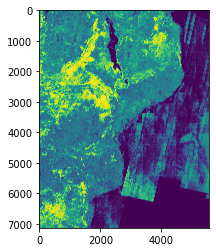

In [12]:
plt.imshow(y_out)

In [13]:
prof.update(count=1)
with rio.open(pred_out, "w", **prof) as ds:
    ds.write(y_out.astype(np.float32), indexes=1)

## Manifold method?
Takes too long

In [14]:
# from sklearn.manifold import Isomap
# im = Isomap(n_components=2)
# y = im.fit_transform(X)  # takes too long!